# MFCC theory and implementation

## Theory

Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

Lets first understand how humans perceive sounds.

## Human voice sound perception

Adult humans fundamental voice frequency range is between 85Hz to 255Hz. On top of the fundamental frequency we note harmonics which are multiples of the fundamental frequency.

You can see an example in the image below [1] which shows time vs. frequency of several pronounced words. Color represents frequency power at that point (yellow strongest and black weakest):

<img src="../../images/speechsep-2-spect.png" width=600 height=200>
<br clear="all" />

Notice the first horizontal yellow line on the bottom of each segment. That is the fundamental frequency, above that there are harmonics with the same frequency distance from each other.

Humans can hear roughly between 20Hz to 20KHz. The perception of sound is non-linear [2] and you can better distinguish between low frequency sounds than high frequency sounds (e.g. humans can clearly hear the difference between 100Hz and 200Hz but not between 15kHz and 15.1kHz). You can try it by using a tone generator: http://www.szynalski.com/tone-generator/.

## MEL scale

A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another [3], [4]. Because of how humans perceive sound the MEL scale is a non-linear scale and the distances between the pitches increase with frequency.


# MFCC implementation 

## Sample signal

First, load a sample audio and start working with it [5], [6]:

In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
TRAIN_PATH = '../../audio/audio_train/'
ipd.Audio(TRAIN_PATH + "a439d172.wav")

In [3]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "a439d172.wav")
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 44100Hz
Audio duration: 6.12s


**Bonus:** notice that the sample rate is 44.1kHz which is the standard sampling rate for audio files. This number is not a coincidence. Acording to Nyquist, that sampling rate of 44.1kHz give us a band-width of 22.05kHz. The 0Hz to 22.05kHz zone is called the *first Nyquist zone*, 22.05kHz to 44.1kHz is the *second Nyquist zone* and so on. If there is a signal in the second Nyquist zone (lets say 22.1kHz) it will alias to the first Nyquist zone (22kHz in our case). We don't want this to happen so we add a low pass filter (LPF). All LPFs have a pass-band, a stop-band and a transition-band: 

<img src="../../images/LPF-img855.png" width=400 height=1>
<br clear="all" />

The sampling frequency of 44.1kHz was chosen so that the transition band will be from 20kHz (pass-band) to 22.05kHz (stop-band). It is important to have at least half of the transition band inside the *first Nyquist zone* because there is still not enough attenuation so there might be aliases from the *second Nyquist zone*.

In [4]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

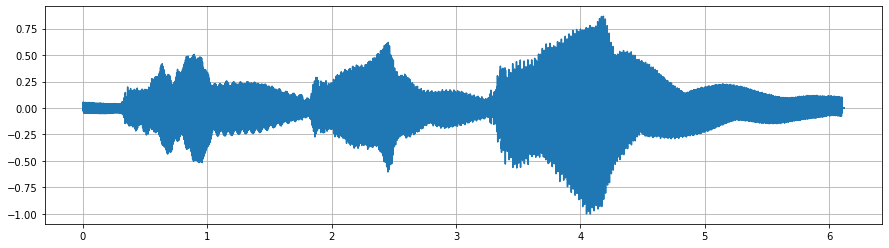

In [5]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

It sounds that we should get high and low fundamental frequencies!!!

## Audio Framing

Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short period of time. Because of that we divide the signal into short frames. Each audio frame will be the same size as the FFT. 

Also we want the frames to *overlap*. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [6]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    print(frame_len, frame_num)
    frames = np.zeros((frame_num,FFT_size))
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

In [7]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

662 408
Framed audio shape: (408, 2048)


Now we have framed audio matrix with the size of `frame_num` x `FFT_size`.

In [8]:
print("First frame:")
audio_framed[1]

First frame:


array([-0.00473261, -0.00473261, -0.00662565, ..., -0.03786086,
       -0.03691434, -0.04117369])

In [9]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([ 0.01135826,  0.01183152,  0.01656413, ...,  0.        ,
        0.        , -0.00141978])

## Convert to frequency domain

Now we will convert the audio, which is currently in time domain to frequency domain. The FFT assumes the audio to be periodic and continuous. By framing the signal we assured the audio to be continuous. To make the audio periodic, we need to apply a window function on every frame. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window [7].

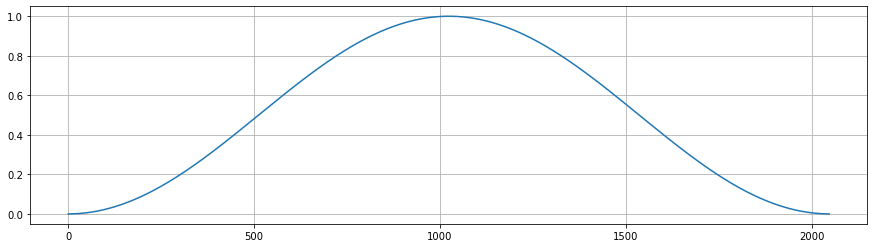

In [10]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

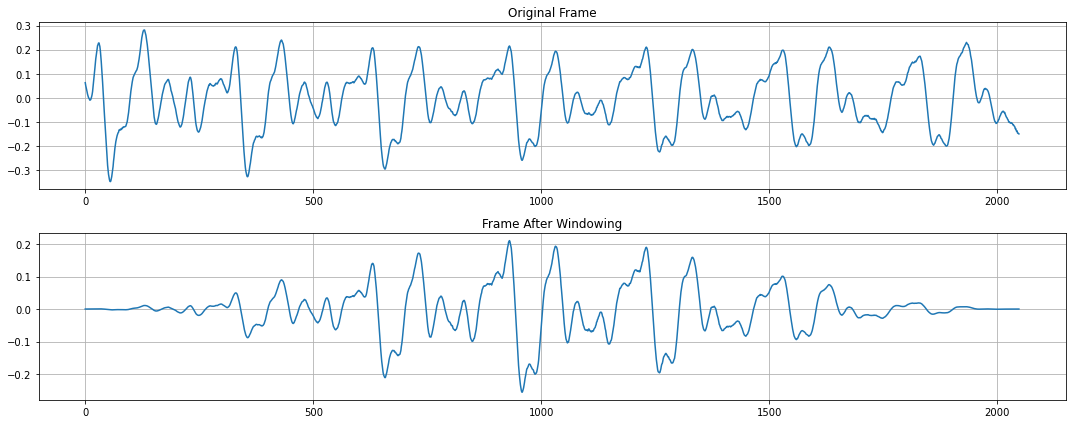

In [11]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)
plt.tight_layout()

Now let's perform the FFT. After that we only take the positive part of the spectrum (first half + `1`).

In [12]:
audio_winT = np.transpose(audio_win)
audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
audio_fft = np.transpose(audio_fft)

## Calculate signal power

In [13]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(408, 1025)


## MEL-spaced filterbank

Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band.

In the case of MEL-spaced filterbank, the spacing between the filters grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [14]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


### Compute filter points
First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

This process is shown in the picture below:

<img src="../../images/MEL.png" alt="MEL" border="0">
<br clear="all" />

In [15]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [16]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
 
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [17]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)

print(mel_freqs)
print(filter_points)

MEL min: 0.0
MEL max: 3923.337321740179
[    0.           260.59867204   618.21401246  1108.96375691
  1782.4116895   2706.57338913  3974.785534    5715.13253718
  8103.38256596 11380.73943188 15878.20322216 22050.        ]
[   0   12   28   51   82  125  184  265  376  528  737 1024]


### Construct the filterbank

Once we have the filter points, the filters are constructed as follows:

In [18]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

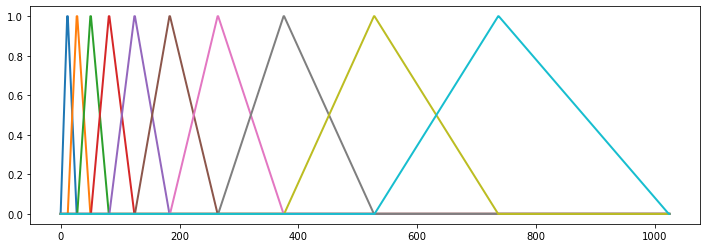

In [19]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(12,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n],lw=2)

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we don't normalize the filters, we will see the noise increase with frequency because of the filter width.

In [20]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

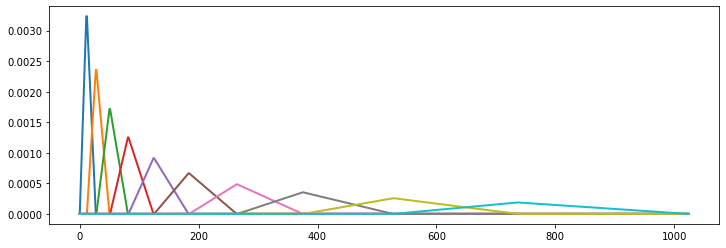

In [21]:
plt.figure(figsize=(12,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n],lw=2)

## Filter the signal

In [22]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 408)

Now we have a matrix representing the audio power through all the filters in different time frames.

## Generate the Cepstral Coefficients

The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal [8], [9].

In [23]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0,:] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1,2*filter_len,2)*np.pi/(2.0*filter_len)

    for i in range(1,dct_filter_num):
        basis[i,:] = np.cos(i*samples)*np.sqrt(2.0/filter_len)
        
    return basis

In [24]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficients = np.dot(dct_filters, audio_log)
cepstral_coefficients.shape

(40, 408)

/home/ale/miniconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/ale/miniconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


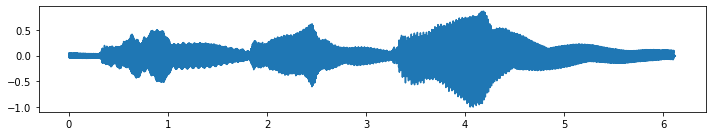

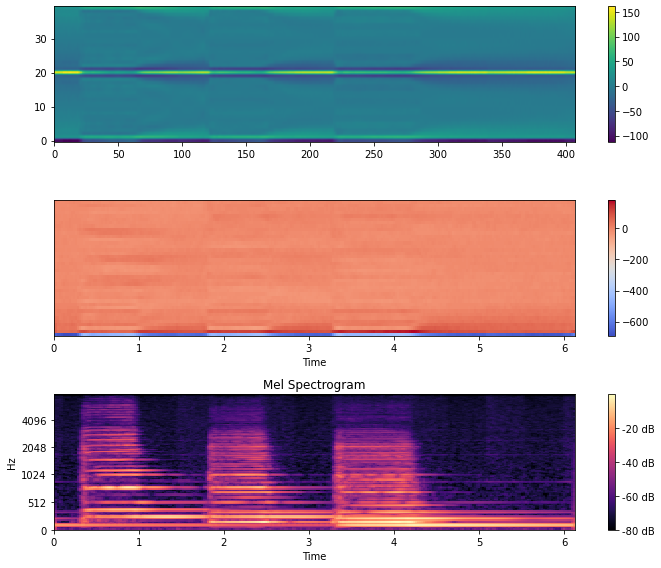

In [37]:
plt.figure(figsize=(10,2))
plt.plot(np.linspace(0,len(audio)/sample_rate,num=len(audio)), audio)
plt.tight_layout()

plt.figure(figsize=(10,8))

plt.subplot(3, 1, 1)
plt.imshow(cepstral_coefficients, aspect='auto', origin='lower')
plt.colorbar()
plt.tight_layout()

########## empleando Librosa ##########
from librosa import display
import librosa
y, sr = librosa.load(TRAIN_PATH + "a439d172.wav")

# Cepstral Coeffs. 
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=dct_filter_num)
plt.subplot(3, 1, 2)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.tight_layout()

# Mel Spectrogram 
mel_spect = librosa.feature.melspectrogram(y, sr)
mel_spect_dB = librosa.power_to_db(mel_spect, ref=np.max)
plt.subplot(3, 1, 3)
librosa.display.specshow(mel_spect_dB, x_axis='time', y_axis='mel', fmax=8000)
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');
plt.tight_layout()

# Bibliography

[1] https://en.wikipedia.org/wiki/Voice_frequency

[2] https://en.wikipedia.org/wiki/Hearing_range

[3] https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html

[4] https://en.wikipedia.org/wiki/Mel_scale

[5] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

[6] https://librosa.github.io/librosa/

[7] https://en.wikipedia.org/wiki/Window_function#Hamming_window

[8] https://www.youtube.com/watch?v=Q2aEzeMDHMA

[9] https://en.wikipedia.org/wiki/Discrete_cosine_transform